In [ ]:
pip install -U ydata-profiling

In [ ]:
import pandas as pd
from ydata_profiling import ProfileReport
import re
import json

# 1. Read in Data

In [ ]:
file_path = "/content/Tripfile_Beispieldaten.csv"

In [ ]:
data = pd.read_csv(file_path, delimiter=';', quotechar='"', engine='python')

# 2. Understanding the Data

In [ ]:
profile = ProfileReport(data, title="Profiling Report - Lufthansa")

In [ ]:
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

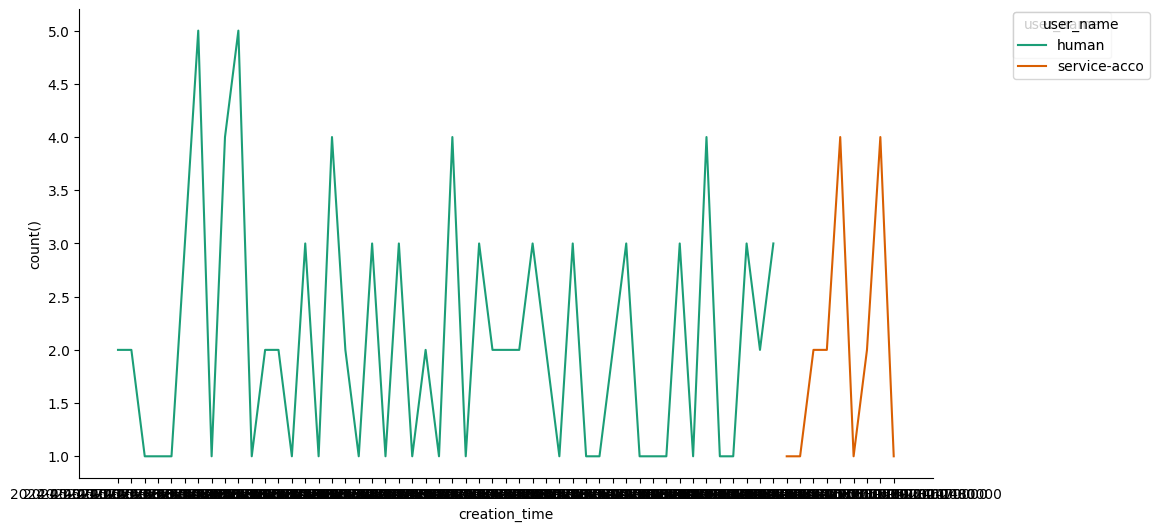

In [ ]:
# @title creation_time vs count()

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['creation_time']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'creation_time'}, axis=1)
              .sort_values('creation_time', ascending=True))
  xs = counted['creation_time']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('creation_time', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('user_name')):
  _plot_series(series, series_name, i)
  fig.legend(title='user_name', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('creation_time')
_ = plt.ylabel('count()')

In [ ]:
data["action_name"].unique()

array(['CalculateWeightAndTrimAction', 'EstimateStorePaxDataAction',
       'StorePaxDataAction', 'AutoLoadBulkAction', 'AssignLoadplanAction',
       'UpdateFlightAction', 'AssignLCCAction',
       'GetCabinConfigurationsAction',
       'StoreRegistrationAndConfigurationAc', 'UpdateCrewDataAction',
       'TransferCargoAction', 'AssignUnassignViewAction',
       'AutomaticNotificationAction', 'CreateZFWMessageAction',
       'CreateBaggageLoadItemsAction', 'UpdateLoadTableAction',
       'UpdateFuelDataAction', 'CreateLoadingInstructionAction',
       'CargoFinalAction', 'RampFinalAction', 'CreateLoadsheetAction'],
      dtype=object)

# 2. Process the Data

In [ ]:
# List of all keys, including weights, indices, and specific aircraft parameters
weight_keys = [
    "START_WI weight",
    "START_WI index",
    "DO_WI weight",
    "DO_WI index",
    "PAX_WI weight",
    "PAX_WI index",
    "TOTAL_DEADLOAD_WI weight",
    "TOTAL_DEADLOAD_WI index",
    "TOTAL_LOAD_WI",
    "TOTAL_TRAFFIC_LOAD",
    "FUEL_INDEX",
    "AZFW",
    "ATOW",
    "ALAW",
    "FUEL_INDEX",
    "AFT_LIMIT_ZFW",
    "Start Weight",
    "Start Index",
    "Total Weight",
    "Index",
    "ATXW",
    "FWD_LIMIT_ZFW"
]

# Create the regex pattern dynamically from the list of keys
pattern = rf'({"|".join(map(re.escape, weight_keys))})\s*:\s*([0-9.]+)'

# Define a function to extract the relevant details
def extract_weight_details(data_string):
    extracted_data = re.findall(pattern, data_string)
    return {key.strip(): float(value) for key, value in extracted_data}

# Apply the function to the 'entry_details' column
data['extracted_data'] = data['entry_details'].astype(str).apply(extract_weight_details)

# Convert extracted dictionary into separate columns
for key in weight_keys:
    data[key] = data['extracted_data'].apply(lambda x: x.get(key, None))

In [ ]:
data.to_csv("tripfile_extracted_weights.csv")